# GLM: Hierarchical Linear Regression with ADVI

First, we'll load the data: 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

data = pd.read_csv('../data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values
n_counties = len(data.county.unique())

In [2]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval to model.
Applied interval-transform to eps and added transformed eps_interval to model.


In [3]:
with hierarchical_model:
    means, sds, elbos = pm.variational.advi(n=100000)

Iteration 0 [0%]: ELBO = -3704.43
Iteration 10000 [10%]: Average ELBO = -3939.29
Iteration 20000 [20%]: Average ELBO = -2251.28
Iteration 30000 [30%]: Average ELBO = -1278.92
Iteration 40000 [40%]: Average ELBO = -1118.14
Iteration 50000 [50%]: Average ELBO = -1103.09
Iteration 60000 [60%]: Average ELBO = -1099.74
Iteration 70000 [70%]: Average ELBO = -1098.89
Iteration 80000 [80%]: Average ELBO = -1098.35
Iteration 90000 [90%]: Average ELBO = -1098.18
Finished [100%]: Average ELBO = -1098.13


In [4]:
# Inference button (TM)!
with hierarchical_model:
    #start = pm.find_MAP()
    step = pm.NUTS(scaling=means)
    hierarchical_trace = pm.sample(5000, step, start=means, progressbar=False)

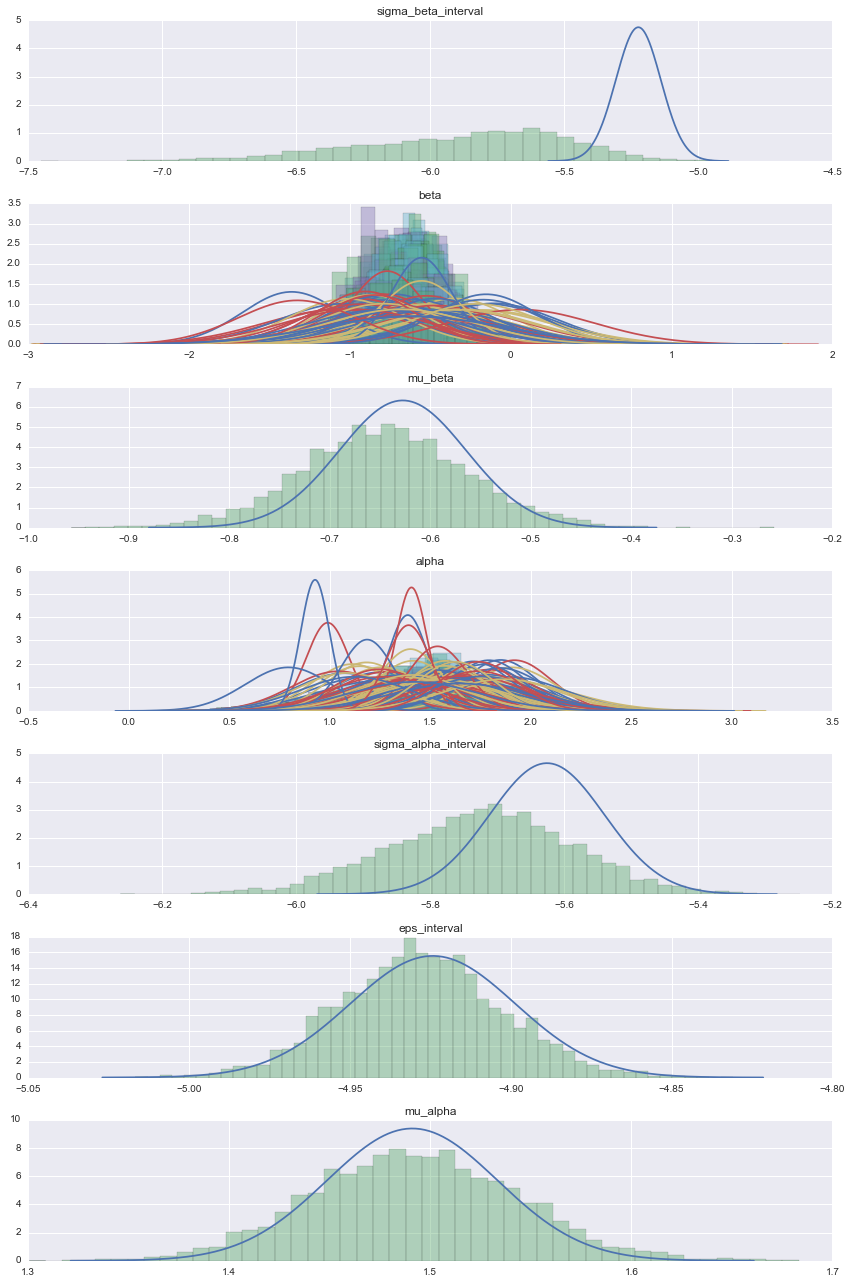

In [5]:
from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if hierarchical_trace[var].ndim > 1:
            t = hierarchical_trace[var][i]
        else:
            t = hierarchical_trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()

Plotting the hierarchical model trace -its found values- from 500 iterations onwards (right side plot) and its accumulated marginal values (left side plot) 

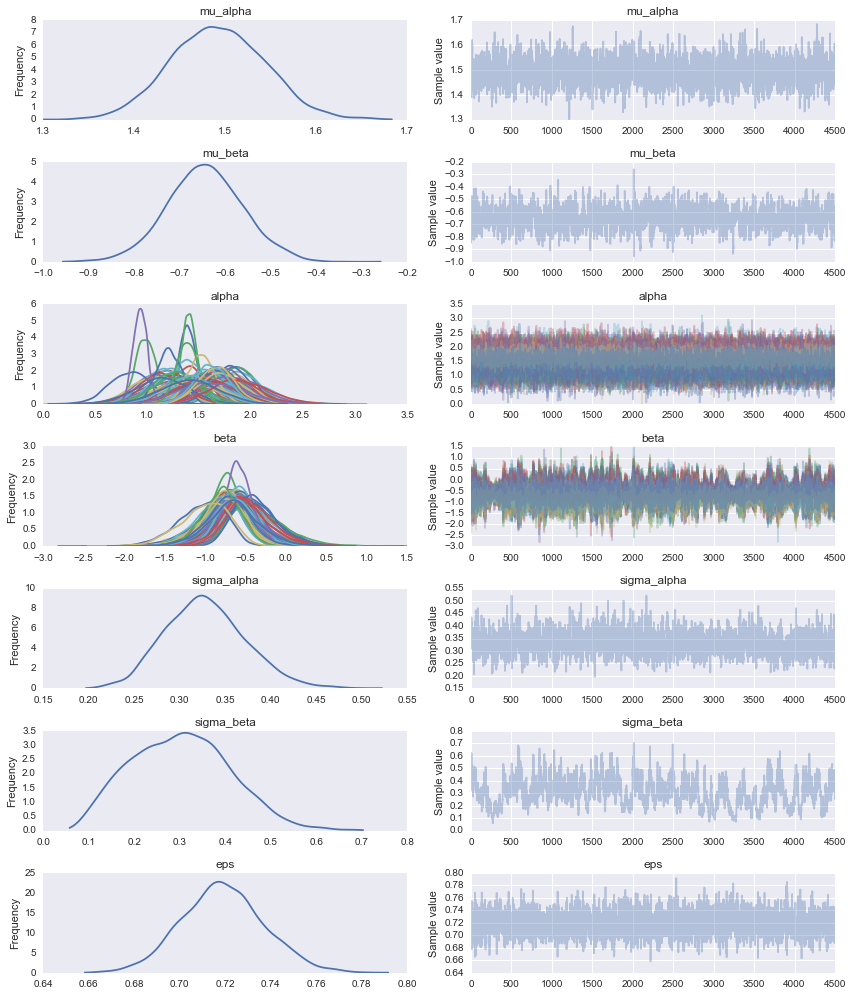

In [6]:
pm.traceplot(hierarchical_trace[500:]);

The marginal posteriors in the left column are highly informative. `mu_a` tells us the group mean (log) radon levels. `mu_b` tells us that having no basement decreases radon levels significantly (no mass above zero). We can also see by looking at the marginals for `a` that there is quite some differences in radon levels between counties (each 'rainbow' color corresponds to a single county); the different widths are related to how much confidence we have in each paramter estimate -- the more measurements per county, the higher our confidence will be.

## Posterior Predictive Check

### The Root Mean Square Deviation

To find out which of the models explains the data better we can calculate the Root Mean Square Deviaton (RMSD). This posterior predictive check revolves around recreating the data based on the parameters found at different moments in the chain. The recreated or predicted values are subsequently compared to the real data points, the model that predicts data points closer to the original data is considered the better one. Thus, the lower the RMSD the better.

When computing the RMSD (code not shown) we get the following result:

  * individual/non-hierarchical model: 0.13
  * hierarchical model: 0.08

As can be seen above the hierarchical model performs better than the non-hierarchical model in predicting the radon values. Following this, we'll plot some examples of county's showing the actual radon measurements, the hierarchial predictions and the non-hierarchical predictions. 

In [7]:
# Non-hierarchical model runs
selection = ['CASS', 'CROW WING', 'FREEBORN']

indiv_traces = {}
for county_name in selection:
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        # Intercept prior (variance == sd**2)
        a = pm.Normal('alpha', mu=0, sd=100**2)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=100**2)
    
        # Model error prior
        eps = pm.Uniform('eps', lower=0, upper=100)
    
        # Linear model
        radon_est = a + b * c_floor_measure
    
        # Data likelihood
        radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(2000, progressbar=False)
    
    # keep trace for later analysis
    indiv_traces[county_name] = trace

Applied interval-transform to eps and added transformed eps_interval to model.
Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to eps_interval
Applied interval-transform to eps and added transformed eps_interval to model.
Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to eps_interval
Applied interval-transform to eps and added transformed eps_interval to model.
Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to eps_interval


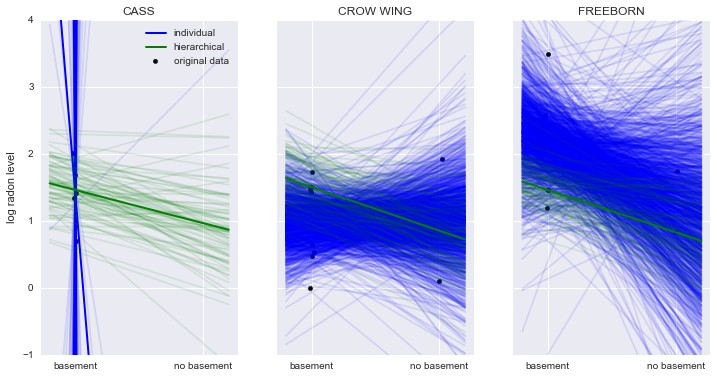

In [8]:
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data.ix[data.county == c]
    c_ind = np.where(county_names==c)[0][0]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(indiv_traces[c]['alpha'][500:], indiv_traces[c]['beta'][500:]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, indiv_traces[c]['alpha'][500:].mean() + indiv_traces[c]['beta'][500:].mean() * xvals, 
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(hierarchical_trace['alpha'][500:][z], hierarchical_trace['beta'][500:][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['alpha'][500:][z].mean() + hierarchical_trace['beta'][500:][z].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In the above plot we have the data points in black of three selected counties. The thick lines represent the mean estimate of the regression line of the individual (blue) and hierarchical model (in green). The thinner lines are regression lines of individual samples from the posterior and give us a sense of how variable the estimates are.

When looking at the county 'CASS' we see that the non-hierarchical estimation is strongly biased: as this county's data contains only households with a basement the estimated regression produces the non-sensical result of a giant negative slope meaning that we would expect negative radon levels in a house without basement!

Moreover, in the example county's 'CROW WING' and 'FREEBORN' the non-hierarchical model appears to react more strongly than the hierarchical model to the existance of outliers in the dataset ('CROW WING': no basement upper right. 'FREEBORN': basement upper left). Assuming that there should be a higher amount of radon gas measurable in households with basements opposed to those without, the county 'CROW WING''s non-hierachical model seems off. Having the group-distribution constrain the coefficients we get meaningful estimates in all cases as we apply what we learn from the group to the individuals and vice-versa.